In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from pytorch_model_summary import summary
from helpers import *

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
size = 32
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Grayscale(), Resize((size, size)), ToTensor()])

In [5]:
root = 'chest_xray/train'
train_data = create_dataset(root, transformation)
train_loader = produce_loader(train_data, batch_size, shuffle=True)

In [6]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [7]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[23, 5116, 3572, 4813, 1458, 5040, 792, 1847, 839]


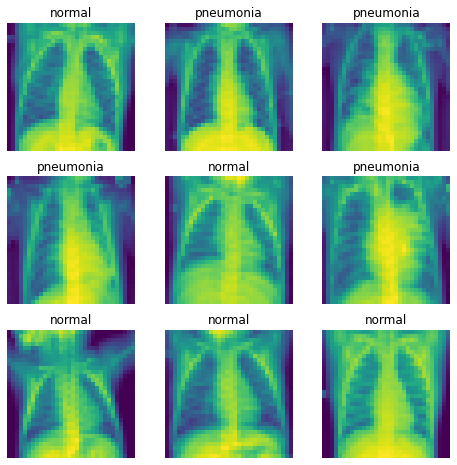

In [8]:
visualize_data(train_data)

[327, 454, 478, 404, 281, 577, 417, 70, 368]


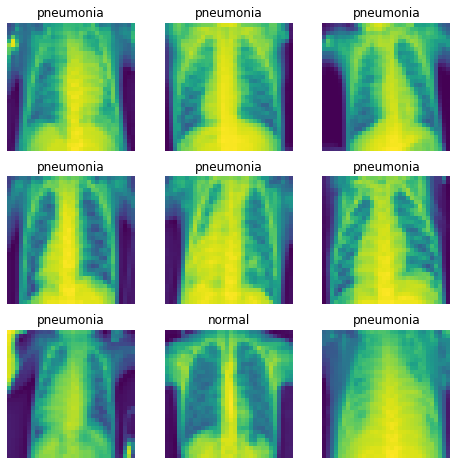

In [9]:
visualize_data(test_data)

In [10]:
resnet = models.resnet34(pretrained=True).to(device)
print(resnet)

C:\Users\varsh\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\varsh\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
resnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)

In [12]:
for param in resnet.parameters():
    param.requiresGrad = False
resnet.conv1.requiresGrad = True

In [13]:
resnet.fc = torch.nn.Sequential(resnet.fc, torch.nn.Linear(1000, 2))
print(resnet)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False,weight_decay=1e-5):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [148]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
optimizer = create_adam_optimizer(resnet, lr = 0.001)
epochs=20

tl, ta, vl, va = train(device, resnet.to(device),
                       train_loader, val_loader, 
                       optimizer, epochs = 2)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/2, Batch number: 0, Cumulated accuracy: 0.484375
Epoch 1/2, Batch number: 5, Cumulated accuracy: 0.6888020833333334
Epoch 1/2, Batch number: 10, Cumulated accuracy: 0.7727272727272727
Epoch 1/2, Batch number: 15, Cumulated accuracy: 0.8154296875
Epoch 1/2, Batch number: 20, Cumulated accuracy: 0.8381696428571429
Epoch 1/2, Batch number: 25, Cumulated accuracy: 0.8572716346153846
Epoch 1/2, Batch number: 30, Cumulated accuracy: 0.8686995967741935
Epoch 1/2, Batch number: 35, Cumulated accuracy: 0.8763020833333334
Epoch 1/2, Batch number: 40, Cumulated accuracy: 0.8850990853658537
Epoch 1/2, Batch number: 45, Cumulated accuracy: 0.8901154891304348
--- Epoch 1/2: Train loss: 0.2907, Train accuracy: 0.8905
--- Epoch 1/2: Val loss: 1.1860, Val accuracy: 0.7316
Epoch 2/2, Batch number: 0, Cumulated accuracy: 0.9296875
Epoch 2/2, Batch number: 5, Cumulated accuracy: 0.9453125
Epoch 2/2, Batch number: 10, Cumulated accuracy: 0.9431818181818182
Epoch 2/2, Batch number: 15, Cumulated acc

In [117]:
torch.save({'model_state_dict': resnet.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict()}, 
           './resnet1')



In [16]:
resnet.load_state_dict(torch.load("./resnet1")["model_state_dict"])

<All keys matched successfully>

Test loss: 0.2526, Test accuracy: 0.9060
Precision: 0.9061135371179039
Recall: 0.9718969555035128
F1 score: 0.9378531073446327


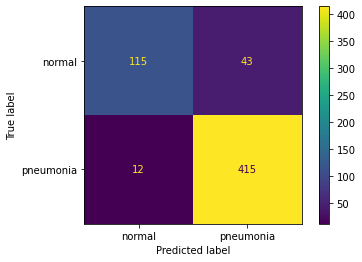

In [18]:
true_labels, model_preds, test_loss, test_accuracy = test(device, resnet.to(device), test_loader, get_predictions=True)
show_metrics(true_labels, model_preds)

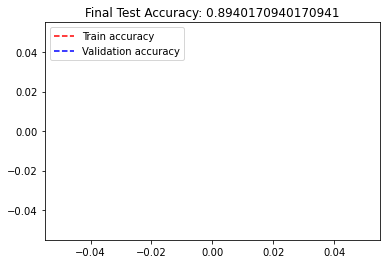

In [119]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

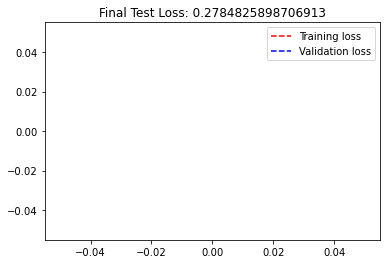

In [120]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()